# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [392]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Point, Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [281]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('catalog.csv')
etas_declustered = pd.read_csv('etas_declustered.csv')

## 2.1 Analyze correlation between all events (n=12573) and surface mass loading by mascon

###  This method calculates LgE and L using mascons from the JPL mascon placement file

In [3]:
'''
Calculates conditional probability P(E|L) using loads during earthquakes (LgE) and loads during all time periods (L)

'''

def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-80,80,80)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [4]:
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')
mascon_center_lat = mascon['mascon_lat'].data
mascon_center_lon = mascon['mascon_lon'].data
mascon_id = mascon['mascon_id'].data

lwe_data = ds.lwe_thickness
cap_radius_deg = 1.5  # Spherical cap radius in degrees

In [5]:
'''
Full catalog - Convert earthquake data to a GeoDataFrame
'''
# Convert longitude and latitude coordinates to Shapely Point objects for spatial operations
geometry_full = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]

# Create a GeoDataFrame with the full earthquake catalog
catalog_gdf_full = gpd.GeoDataFrame(catalog, geometry=geometry_full, crs="EPSG:4326")  
# EPSG:4326 specifies the coordinate reference system (WGS 84)

# Create a spatial index for fast spatial queries (used for spatial joins)
catalog_gdf_full.sindex  # Improves efficiency when searching for earthquakes within regions


'''
ETAS Declustered Catalog - Convert ETAS declustered earthquake data to a GeoDataFrame
'''
# Convert ETAS declustered catalog's coordinates into Shapely Point objects for spatial analysis
geometry_etas = [Point(xy) for xy in zip(etas_declustered['longitude'], etas_declustered['latitude'])]

# Create a GeoDataFrame specifically for the ETAS declustered catalog
catalog_gdf_etas = gpd.GeoDataFrame(etas_declustered, geometry=geometry_etas, crs="EPSG:4326")

# Create a spatial index for fast spatial queries in the ETAS declustered dataset
catalog_gdf_etas.sindex  # This allows quick lookups for earthquake locations


In [6]:
def calc_cp_by_mascon(catalog_gdf, loads):
    """
    Calculates conditional probability P(E|L) in every mascon using each mascon's center coordinates 
    and creating a 1.5-degree radius spherical cap around each one.
    
    Parameters:
    - catalog_gdf (GeoDataFrame): A GeoDataFrame containing earthquake data with spatial geometry.
    - loads (xarray DataArray): GRACE-derived surface load dataset.

    Returns:
    - cp_averaged (numpy array): Averaged conditional probabilities P(E|L) across all mascons.
    - bins (numpy array): Bin edges used for probability computation.
    """
    
    cp = []  # List to store conditional probabilities for each mascon

    # Iterate through each mascon center
    # tqdm can be used for progress tracking if needed
    for i in range(len(mascon_id)):
        # Create a Shapely Point object for the mascon center
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])

        # Define a circular buffer (spherical cap) with a 1.5-degree radius
        bbox = center_point.buffer(cap_radius_deg)

        # Convert the buffer to a GeoDataFrame for spatial operations
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Perform a spatial join to find earthquakes located within the spherical cap
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')

        # If no earthquakes are found within this cap, move to the next mascon
        if these_earthquakes.empty:
            continue

        # Retrieve surface load data for this mascon at its center coordinates
        L = loads.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest").data.flatten()

        # Extract load values at the times of earthquakes occurring in this mascon
        LgE = these_earthquakes.dmass  # Load at earthquake times

        # Number of earthquakes in this mascon (used as probability weight)
        E = len(these_earthquakes)  

        # Compute conditional probability P(E|L) for this mascon
        bins, this_cp = get_cp(LgE, L)
        this_cp = this_cp * E  # Weight by earthquake probability

        cp.append(this_cp)  # Store computed P(E|L)

    # Compute the average conditional probability across all mascons
    cp_averaged = np.nanmean(np.array(cp), axis=0)
    
    return cp_averaged, bins

In [7]:
cp_averaged, bins = calc_cp_by_mascon(catalog_gdf_full, lwe_data)

## 2.2 Analyze correlation between events in declustered catalog (n=537) and surface mass loading by mascon

In [8]:
etas_cp_averaged, bins = calc_cp_by_mascon(catalog_gdf_etas, lwe_data)

## 2.3 Visualizing correlation for full & declustered catalog

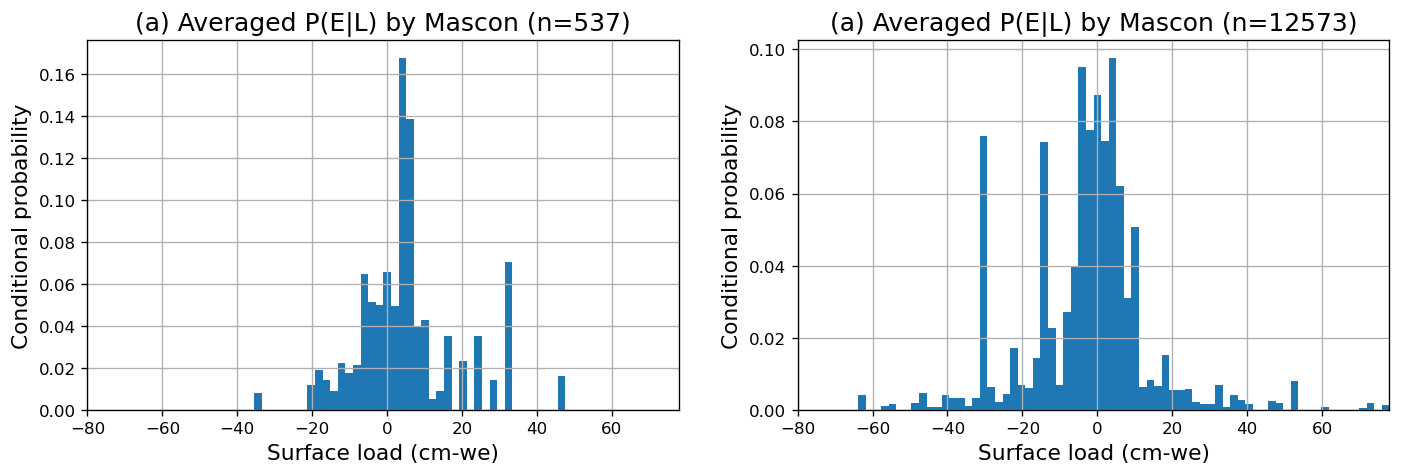

In [9]:
fig, axes = plt.subplots(1,2, figsize=(14, 4), dpi=120)
fs = 13

### (a) P(E|L) by Mascon (ETAS)
wid_etas = np.mean(np.diff(bins))

axes[0].bar(bins[:-1], etas_cp_averaged / np.sum(etas_cp_averaged), 
       width=wid_etas, align='edge')

axes[0].set_xlim(bins[0], bins[-2])
axes[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[0].set_ylabel('Conditional probability', fontsize=fs)
axes[0].set_title('(a) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
axes[0].grid(True)

### (b) P(E|L) by Mascon (full catalog)
axes[1].bar(bins[:-1], cp_averaged / np.sum(cp_averaged), 
       width=wid_etas, align='edge')

axes[1].set_xlim(bins[0], bins[-2])
axes[1].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[1].set_ylabel('Conditional probability', fontsize=fs)
axes[1].set_title('(a) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
axes[1].grid(True)

## 3.1 Permutation testing

### The code below does the following:
1. Scramble loads (ds.lwe_thickness) and generate randomized data
2. Calculate cp for each randomized load dataset

In [10]:
# Number of randomizations
N = 100

In [31]:
'''
Takes ~40 minutes to run
Last run: Feb 19, 2025
'''

# cp_real_distribution = []  # List to store conditional probabilities from each randomization

# # Perform permutation test by shuffling surface loads and recalculating P(E|L)
# for i in tqdm(range(N)):  
#     # Extract the full surface load dataset (GRACE lwe_thickness) as a NumPy array
#     all_grace_data = np.array(ds['lwe_thickness'].values)

#     # Flatten the dataset to enable shuffling while maintaining data integrity
#     flat_grace = all_grace_data.ravel()

#     # Randomly shuffle the flattened surface load data
#     np.random.shuffle(flat_grace)

#     # Reshape the shuffled data back into its original structure
#     shuffled_grace = flat_grace.reshape(all_grace_data.shape)

#     # Create a deep copy of the original dataset to avoid modifying the original 'ds'
#     ds_shuffled = ds.copy(deep=True)

#     # Replace the original surface load data with the shuffled version
#     ds_shuffled['lwe_thickness'].values = shuffled_grace

#     # Recalculate conditional probability P(E|L) using the shuffled dataset
#     cp_shuffled, bins = calc_cp_by_mascon(catalog_gdf_full, ds_shuffled['lwe_thickness'])
#     cp_shuffled = cp_shuffled / np.sum(cp_shuffled) # Normalization
    
#     # Store the computed conditional probabilities from this iteration
#     cp_real_distribution.append(cp_shuffled)

# # Convert the list of probability distributions to a NumPy array for efficient computation
# cp_real_distribution = np.array(cp_real_distribution)  # Shape: (N, num_bins)

100%|███████████████████████████████████| 100/100 [38:00<00:00, 22.81s/it]


## 3.2  Repeating analysis for ETAS declustered catalog

In [125]:
N=100

In [342]:
'''
Takes ~40 minutes to run
Last run: Feb 19, 2025
'''

# etas_cp_real_distribution = []

# # Scramble and calculate cp for each randomization
# for i in tqdm(range(N)):
#     all_grace_data = ds['lwe_thickness'].values
#     flat_grace = all_grace_data.ravel()
#     np.random.shuffle(flat_grace)
#     shuffled_grace = flat_grace.reshape(all_grace_data.shape)

#     ds['lwe_thickness'] = (ds['lwe_thickness'].dims, shuffled_grace)
#     etas_cp_shuffled, bins = calc_cp_by_mascon(catalog_gdf_etas, ds['lwe_thickness'])
#     etas_cp_shuffled = etas_cp_shuffled / np.sum(etas_cp_shuffled)
#     etas_cp_real_distribution.append(etas_cp_shuffled)

# # Convert to NumPy array for proper averaging
# etas_cp_real_distribution = np.array(etas_cp_real_distribution)  # Shape: (N, num_bins)

In [343]:
# Identify significant bins based on conditional probability threshold
sig_ind = norm_cp_etas > significant99

# Get left and right edges of significant bins
sig_bins_left = bins[:-1][sig_ind]   # Left edges
sig_bins_right = bins[1:][sig_ind]   # Right edges

## 4. Figures

### 4.1 Convergence test

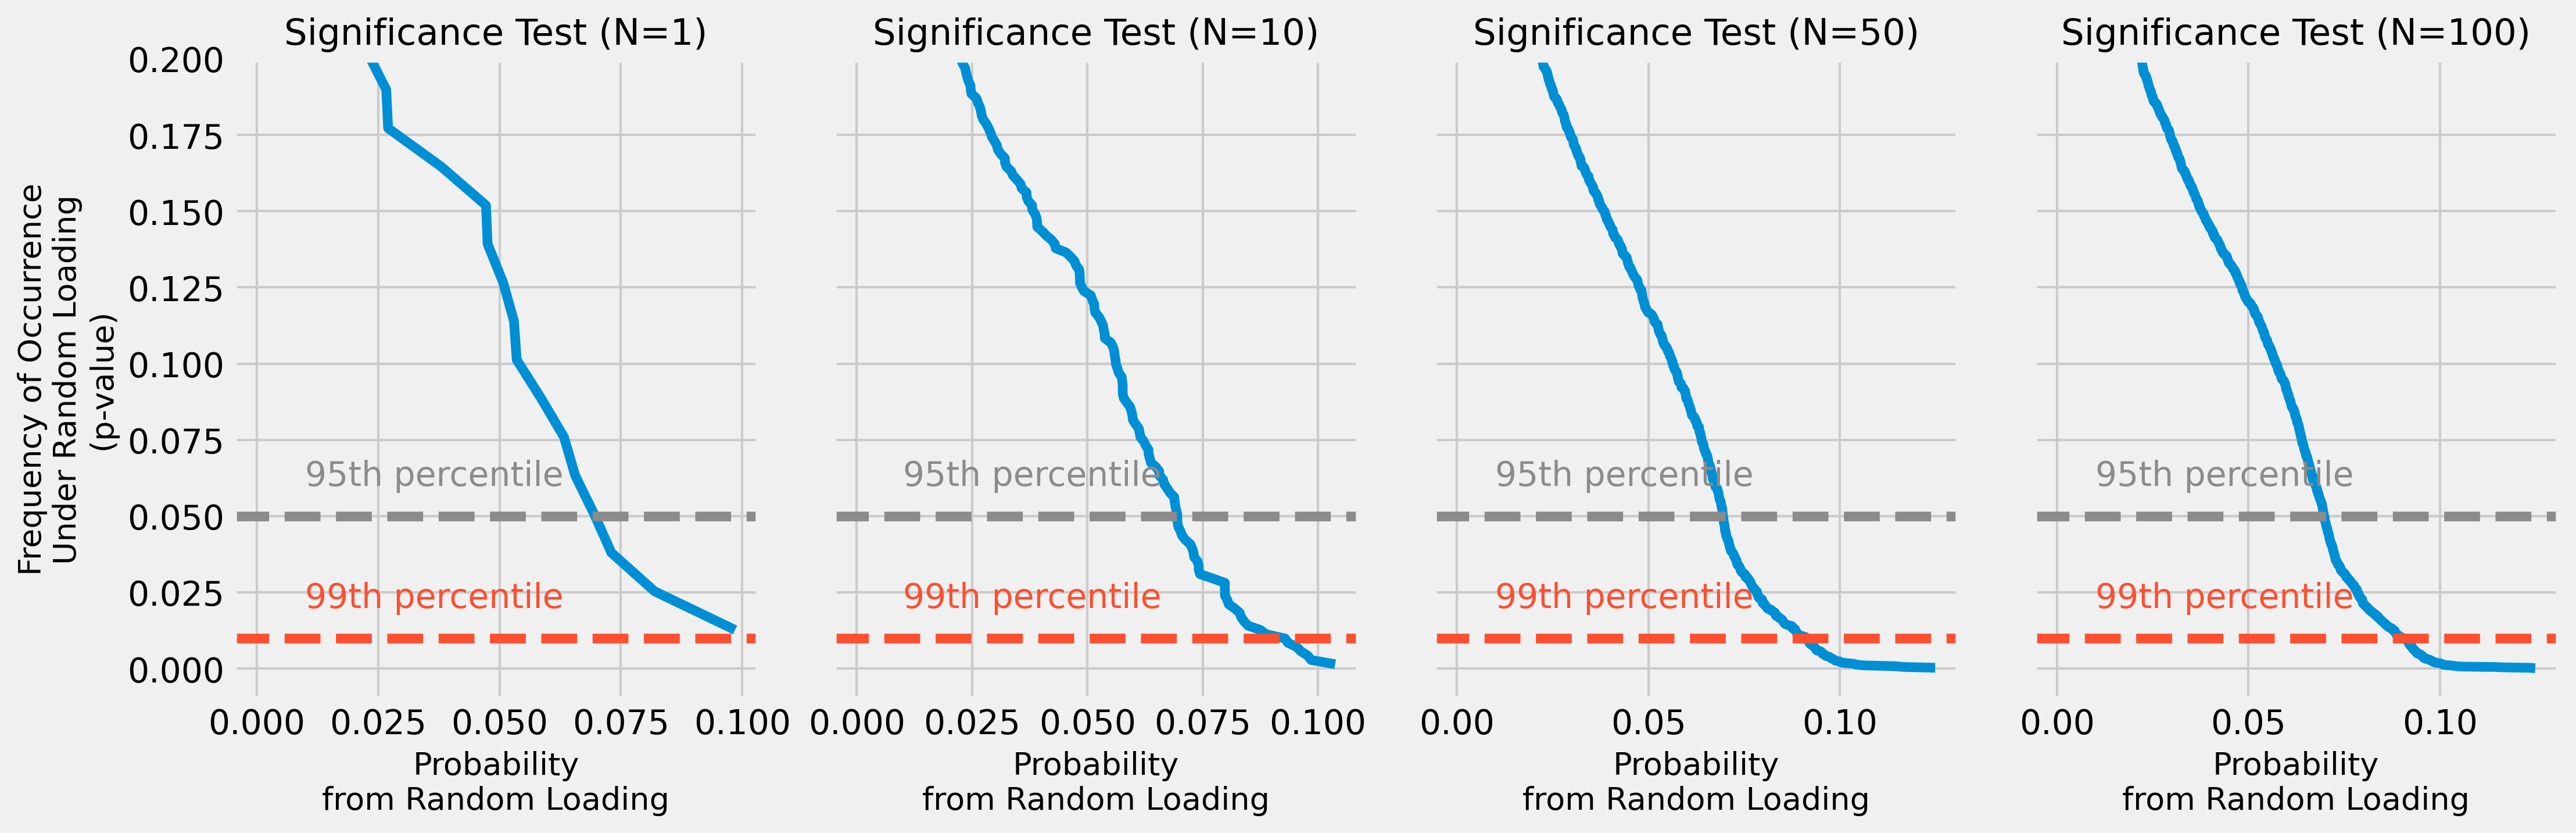

In [436]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), dpi=300, sharey=True)
plt.style.use('fivethirtyeight')
fs = 13

# Define different data slices for each subplot
partial_rds = [
    cp_real_distribution[1, :],
    cp_real_distribution[1:10, :].flatten(),
    cp_real_distribution[1:50, :].flatten(),
    cp_real_distribution[1:100, :].flatten(),
]

titles = [
    "Significance Test (N=1)",
    "Significance Test (N=10)",
    "Significance Test (N=50)",
    "Significance Test (N=100)",
]

# Plot each dataset in the 1x4 figure
for i, (ax, partial_rd, title) in enumerate(zip(axes, partial_rds, titles)):
    sorted_data = np.sort(partial_rd)
    pval = 1 - np.arange(sorted_data.size) / sorted_data.size

    ax.plot(sorted_data, pval)
    ax.set_xlabel("Probability\nfrom Random Loading", fontsize=fs)
    ax.set_title(title, fontsize=fs + 2)
    ax.set_ylim([-0.01, 0.2])
    ax.text(0.01, 0.02, '99th percentile', color='C1')
    ax.text(0.01, 0.06, '95th percentile', color='C4')
    ax.axhline(y=0.01, color="C1", linestyle="--", label="99th percentile")
    ax.axhline(y=0.05, color="C4", linestyle="--", label="95th percentile")

    if i == 0:  # Add ylabel only to the first subplot for clarity
        ax.set_ylabel("Frequency of Occurrence\nUnder Random Loading\n(p-value)", fontsize=fs)
    
    ax.grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()


### 4.2 Significance test & conditional probabilities

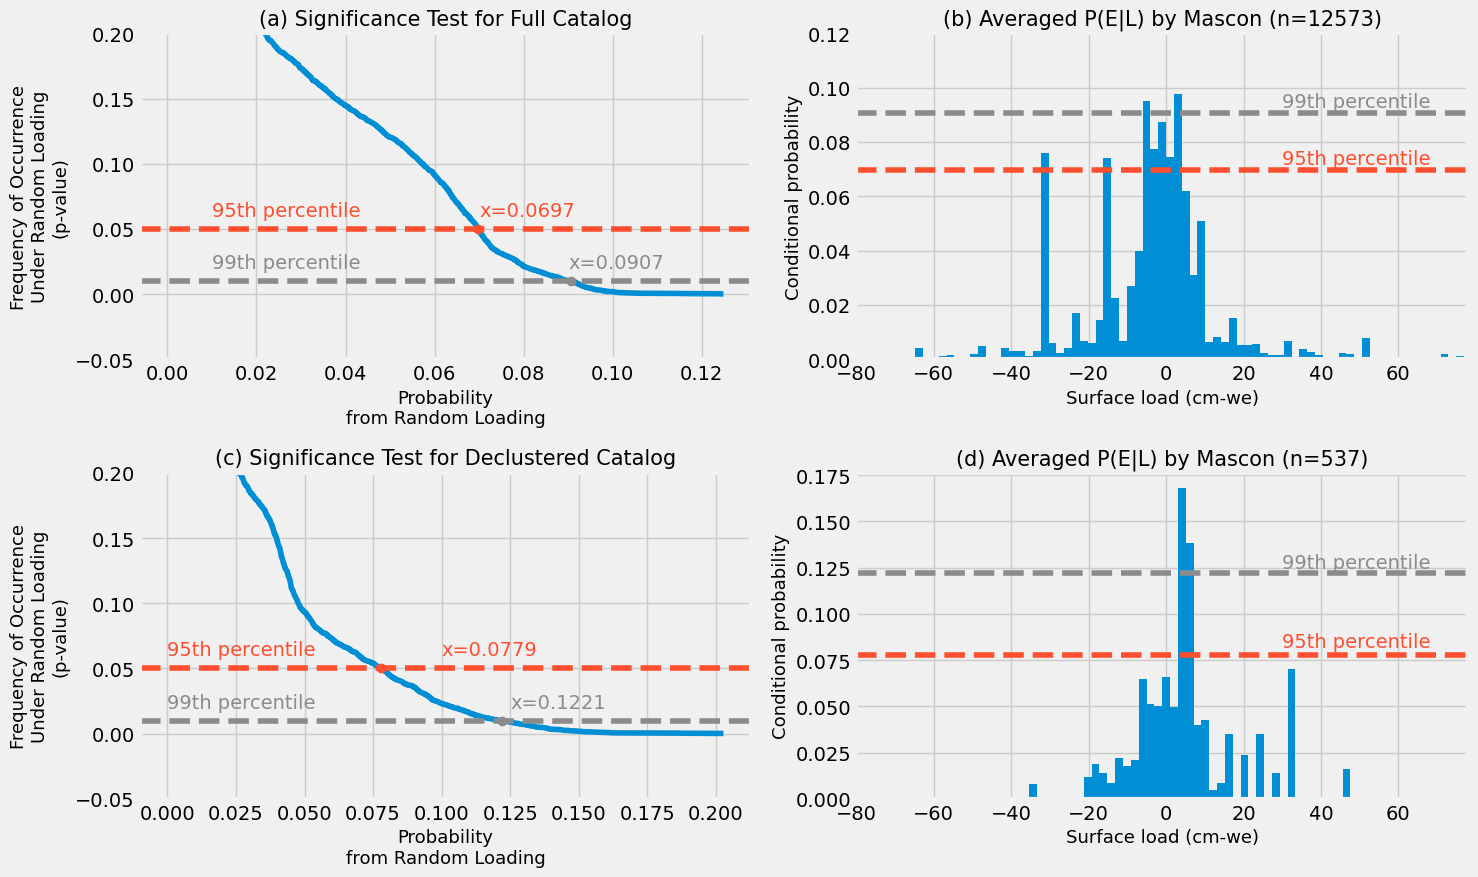

In [430]:
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
fs = 13

### (1) Significance Test for Full Catalog
ax = axes[0, 0]
wid_etas = np.mean(np.diff(bins))
full_dist = cp_real_distribution.flatten()
sorted_data = np.sort(full_dist)
pval = 1 - np.arange(sorted_data.size) / sorted_data.size
ax.plot(sorted_data, pval)
ax.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax.set_title('(a) Significance Test for Full Catalog', fontsize=fs + 2)
ax.set_ylim([-0.05, 0.2])
significant95 = min(sorted_data[pval < 0.05])
significant99 = min(sorted_data[pval < 0.01])

ax.text(0.01, 0.06, '95th percentile', color='C1')
ax.axhline(y=0.05, color='C1', linestyle='--')
ax.plot(significant95, 0.05, 'C1o')
ax.text(0.07, 0.06, 'x=0.0697', color='C1')

ax.text(0.01, 0.02, '99th percentile', color='C4')
ax.axhline(y=0.01, color='C4', linestyle='--')
ax.plot(significant99, 0.01, 'C4o')
ax.text(0.09, 0.02, 'x=0.0907', color='C4')

ax.grid(True)

### (2) P(E|L) by Mascon (Full Catalog)
ax = axes[0, 1]
wid_etas = np.mean(np.diff(bins))
ax.bar(bins[:-1], cp_averaged / np.sum(cp_averaged), width=wid_etas)
ax.set_xlim(bins[0], bins[-2])
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('(b) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
ax.text(30, 0.072, '95th percentile', color='C1')
ax.axhline(y=significant95, color='C1', linestyle='--')
ax.text(30, 0.093, '99th percentile', color='C4')
ax.axhline(y=significant99, color='C4', linestyle='--')
ax.grid(True)
ax.set_ylim([0, 0.12])

### (3) Significance Test for ETAS Declustered Catalog
ax = axes[1, 0]
wid_etas = np.mean(np.diff(bins))
full_dist = etas_cp_real_distribution.flatten()
sorted_data = np.sort(full_dist)
pval = 1 - np.arange(sorted_data.size) / sorted_data.size
ax.plot(sorted_data, pval)
ax.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax.set_title('(c) Significance Test for Declustered Catalog', fontsize=fs + 2)
ax.set_ylim([-0.05, 0.2])
significant95 = min(sorted_data[pval < 0.05])
significant99 = min(sorted_data[pval < 0.01])
ax.text(0, 0.06, '95th percentile', color='C1')
ax.axhline(y=0.05, color='C1', linestyle='--')
ax.plot(significant95, 0.05, 'C1o')
ax.text(0.1, 0.06, 'x=0.0779', color='C1')
ax.text(0, 0.02, '99th percentile', color='C4')
ax.axhline(y=0.01, color='C4', linestyle='--')
ax.plot(significant99, 0.01, 'C4o')
ax.text(0.125, 0.02, 'x=0.1221', color='C4')
ax.grid(True)

### (4) P(E|L) by Mascon (Declustered Catalog)
ax = axes[1, 1]
wid_etas = np.mean(np.diff(bins))
norm_cp_etas = etas_cp_averaged / np.sum(etas_cp_averaged)
ax.bar(bins[:-1], norm_cp_etas, width=wid_etas, align='edge')
ax.set_xlim(bins[0], bins[-2])
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('(d) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
ax.text(30, 0.082, '95th percentile', color='C1')
ax.axhline(y=significant95, color='C1', linestyle='--')
ax.text(30, 0.125, '99th percentile', color='C4')
ax.axhline(y=significant99, color='C4', linestyle='--')

# ax.axvline(sig_bins_left[0], color='C5')
# ax.axvline(sig_bins_right[1], color='C3')
ax.grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()


In [440]:
sig_bins_left

array([3.03797468, 5.06329114])

In [441]:
sig_bins_right

array([5.06329114, 7.08860759])

## 5. Plot significant events in declustered catalog

In [370]:
# Events are defined as significant if their cp is above the 99th percentile of conditional probabilities (between two vertical red lines in plot (d))

sig_events = etas_declustered[(etas_declustered.dmass > sig_bins_left[0]) & (etas_declustered.dmass < sig_bins_right[1])]

# Find the bin index for each event
bin_indices = np.digitize(sig_events["dmass"], bins[:-1]) - 1  # Adjust for 0-based indexing

# Ensure indices are within valid range
bin_indices = np.clip(bin_indices, 0, len(norm_cp_etas) - 1)

# Assign cp to each event
sig_events["cp"] = norm_cp_etas[bin_indices]

/var/folders/8d/yjj_j8x10pd63nrz4jt7rhrh0000gn/T/ipykernel_33854/1442347856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_events["cp"] = norm_cp_etas[bin_indices]


/Users/amandasyamsul/SLIQ/loadquakes.py:327: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


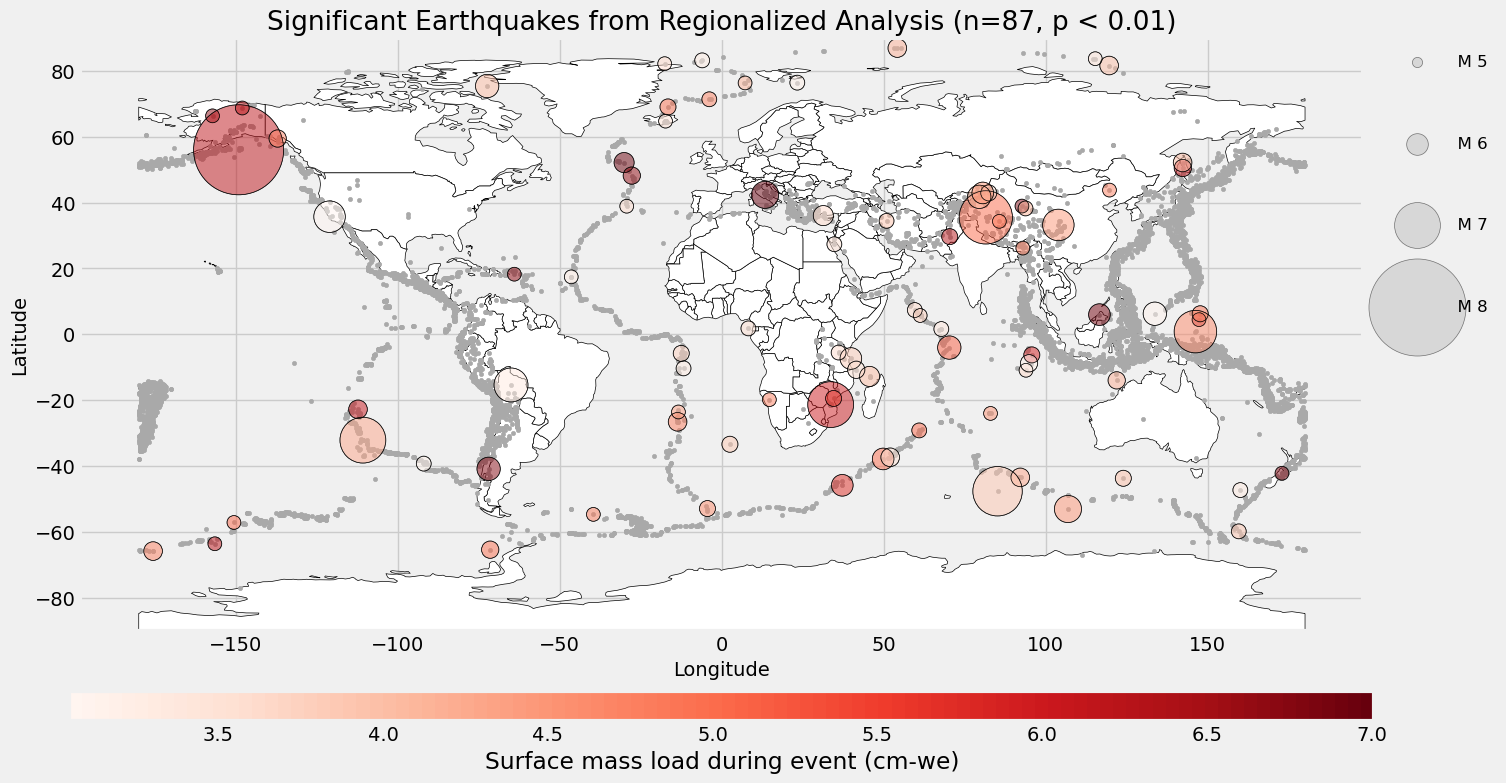

In [437]:
importlib.reload(loadquakes)
plt.style.use('fivethirtyeight')

ax = loadquakes.load_map_cb(
    full_catalog=catalog_gdf_full,  # Full earthquake catalog
    events=sig_events,  # Significant earthquakes (p < 0.05)
    color="dmass",  # Use surface load as the color metric
    title="Significant Earthquakes from Regionalized Analysis (n=87, p < 0.01)",
    vmin=sig_events["dmass"].min(),
    vmax=sig_events["dmass"].max(),
    circle_scale=0.03,  # Adjusted marker size scaling
    markersize_scale=1.5  # Adjusted marker size scaling
)

plt.show()

In [371]:
import geopandas as gpd
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

def grace_snapshot(lat,lon,title,fs,snapshot,ax,cb,loc,pad,fract):
    world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    vm=25
    
    ax.plot(lon,lat,'o', markeredgecolor='black', markerfacecolor='None', markersize=10)
    ax.plot(lon,lat,'o', markeredgecolor='black', markerfacecolor='None', markersize=15)
    
    lonshift = np.array(ds.lon)
    lonshift[lonshift>180] = lonshift[lonshift>180] - 360
    lat = np.array(ds.lat)
    c=ax.pcolormesh(fftshift(lonshift),lat,fftshift(snapshot,axes=1),vmin=-vm,vmax=vm,cmap='coolwarm')
    world.plot(color='none', edgecolor='black',ax=ax,alpha=0.5)
    
    ax.set_title(title, fontsize=fs)
    ax.grid()
    
    if cb:
        plt.colorbar(c, ax=ax, label='Surface load (cm-we)',fraction=fract, pad=pad,location=loc)
    return c

In [372]:
'''
M 7.9 (January, 2018) — 292 km SE of Kodiak, Alaska
'''

ds.sel(time='2018-01-23T12:00:00.000000000', method="nearest")

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    time           datetime64[ns] 2018-06-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (lat, lon) float64 ...
    uncertainty    (lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2022-03-08T07:03:58Z

In [373]:
dataset=ds.time.to_numpy()
index = np.where(dataset == np.datetime64('2018-06-16T00:00:00.000000000'))
print(index)
ds.time.to_numpy()[index]

(array([163]),)


array(['2018-06-16T00:00:00.000000000'], dtype='datetime64[ns]')

/var/folders/8d/yjj_j8x10pd63nrz4jt7rhrh0000gn/T/ipykernel_33854/938143602.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


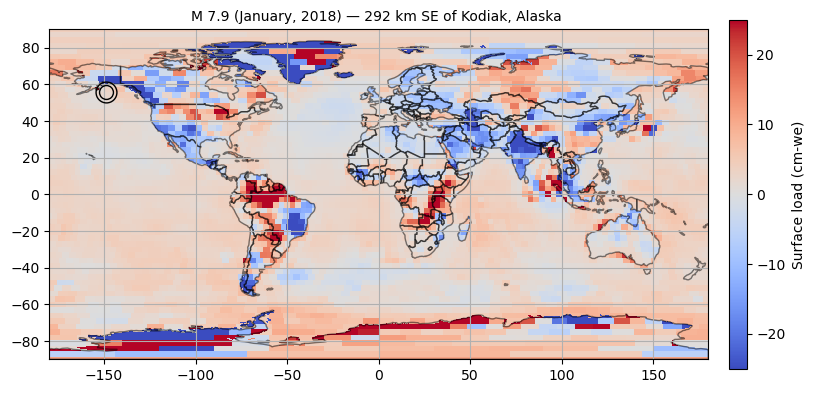

In [374]:
plt.style.use('default')

snapshot = ds.lwe_thickness.to_numpy()[index,:,:].squeeze()
fig,ax = plt.subplots(figsize=(9,9))

grace_snapshot(56.0039,-149.1658,'M 7.9 (January, 2018) — 292 km SE of Kodiak, Alaska ',10,snapshot,ax,True,'right',pad=0.03,fract=0.025)

In [375]:
'''
M 7.1 - southeast Indian Ridge
'''

ds.sel(time='2015-12-04T12:00:00.000000000', method="nearest")

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    time           datetime64[ns] 2015-12-23T12:00:00
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (lat, lon) float64 6.458 6.458 6.458 ... 2.919 2.919 2.919
    uncertainty    (lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2022-03-08T07:03:58Z

In [376]:
dataset=ds.time.to_numpy()
index = np.where(dataset == np.datetime64('2015-12-23T12:00:00.000000000'))
print(index)
ds.time.to_numpy()[index]

(array([148]),)


array(['2015-12-23T12:00:00.000000000'], dtype='datetime64[ns]')

/var/folders/8d/yjj_j8x10pd63nrz4jt7rhrh0000gn/T/ipykernel_33854/938143602.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


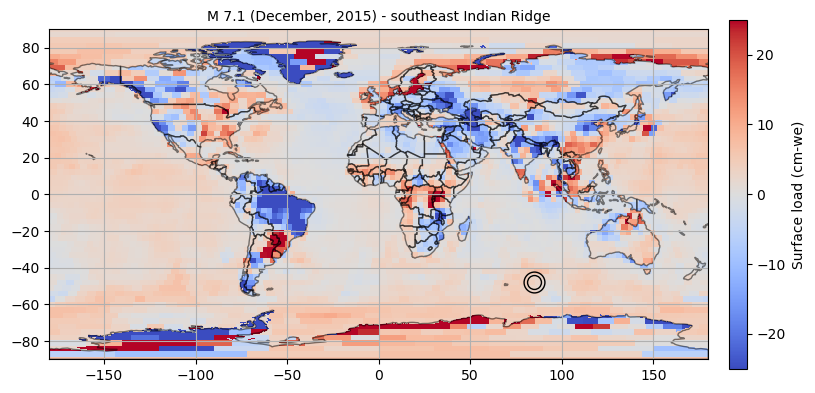

In [377]:
plt.style.use('default')

snapshot = ds.lwe_thickness.to_numpy()[index,:,:].squeeze()
fig,ax = plt.subplots(figsize=(9,9))

grace_snapshot(-47.6165,85.0913,'M 7.1 (December, 2015) - southeast Indian Ridge',10,snapshot,ax,True,'right',pad=0.03,fract=0.025)

In [378]:
'''
M 7.2 - 226 km SE of Hotan, China
'''

ds.sel(time='2008-03-20T12:00:00.000000000', method="nearest")

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    time           datetime64[ns] 2008-03-16T12:00:00
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (lat, lon) float64 -1.571 -1.571 -1.571 ... -3.509 -3.509
    uncertainty    (lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2022-03-08T07:03:58Z

In [379]:
dataset=ds.time.to_numpy()
index = np.where(dataset == np.datetime64('2008-03-16T12:00:00.000000000'))
print(index)
ds.time.to_numpy()[index]

(array([68]),)


array(['2008-03-16T12:00:00.000000000'], dtype='datetime64[ns]')

/var/folders/8d/yjj_j8x10pd63nrz4jt7rhrh0000gn/T/ipykernel_33854/938143602.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


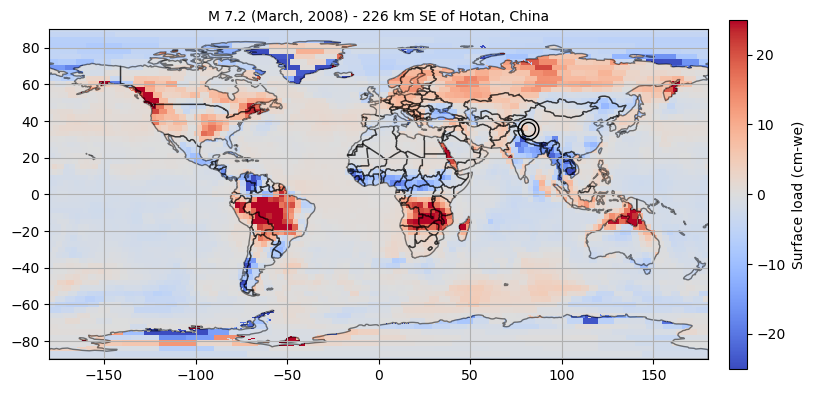

In [380]:
plt.style.use('default')

snapshot = ds.lwe_thickness.to_numpy()[index,:,:].squeeze()
fig,ax = plt.subplots(figsize=(9,9))

grace_snapshot(35.4900,81.4670,'M 7.2 (March, 2008) - 226 km SE of Hotan, China',10,snapshot,ax,True,'right',pad=0.03,fract=0.025)